## libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from tqdm import tqdm_notebook
import scipy.integrate as integrate
import copy
import seaborn as sns
from pathlib import Path

## initialization

In [2]:
STARS_DIRECTORY = Path('../clusters_research/')
MAIN_DIRECTORY = Path('../')

In [67]:
CLUSTER = 'NGC_2099'

In [68]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [69]:
singles_data = read_file(STARS_DIRECTORY / f'{CLUSTER}_separated_singles')

In [74]:
binaries_data = read_file(STARS_DIRECTORY / f'{CLUSTER}_separated_binaries')

## last cleaning

In [70]:
degree = 4
popt = np.polyfit(singles_data['BP_RP'], singles_data['Gmag'],degree)
func_iso = np.poly1d(popt)

isochrone = pd.DataFrame(data = {'BP_RP' : np.linspace(singles_data['BP_RP'].min()-0.05, 
                                                       singles_data['BP_RP'].max()+0.05, 500)})

In [71]:
f = singles_data['Gmag'] - func_iso(singles_data['BP_RP'])

In [72]:
index_to_drop = f[(np.abs(f) > 3 * np.std(f)) & (f > 0)].index
singles_data = singles_data.drop(index_to_drop, axis=0)

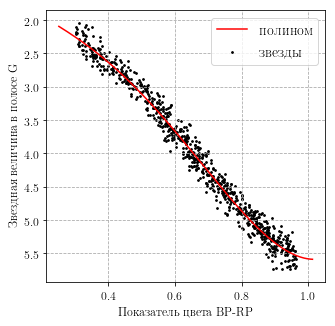

In [73]:
fig, ax = plt.subplots(figsize=(5,5 ))
ax.scatter (singles_data['BP_RP'] , singles_data['Gmag'] , c ='black', s = 3, label ='звезды')
ax.plot(isochrone['BP_RP'],func_iso(isochrone['BP_RP']) , c ='red', lw = 1.5, label ='полином') 
ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)
plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')
plt.show()

## transition to a new coordinate system

In [75]:
degree = 4
popt = np.polyfit(singles_data['BP_RP'], singles_data['Gmag'],degree)
func_iso = np.poly1d(popt)

isochrone = pd.DataFrame(data = {'BP_RP' : np.linspace(singles_data['BP_RP'].min()-0.05, 
                                                       singles_data['BP_RP'].max()+0.05, 500)})


singles_data['Gmag_new'] = singles_data['Gmag'] - func_iso(singles_data['BP_RP'])
binaries_data['Gmag_new'] = binaries_data['Gmag'] - func_iso(binaries_data['BP_RP'])

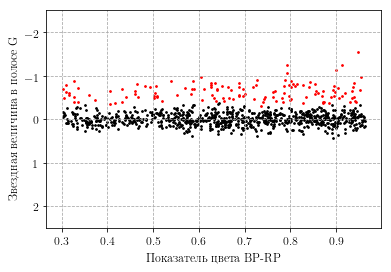

In [76]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter (singles_data['BP_RP'] , singles_data['Gmag_new'] , c ='black', s = 3, label ='звезды')
ax.scatter (binaries_data['BP_RP'] , binaries_data['Gmag_new'] , c ='red', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2.5,2.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
#ax.legend(fontsize = 15)
plt.savefig("horizontal_sequence.pdf", bbox_inches = 'tight')
plt.show()

## density profile

In [77]:
all_stars_data = pd.concat([singles_data,binaries_data])

In [78]:
num_stars = len(all_stars_data)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15)
kde.fit(all_stars_data[['Gmag_new']].to_numpy())

profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile['density'] *= num_stars

Text(0.5, 0, '$G_{new}$')

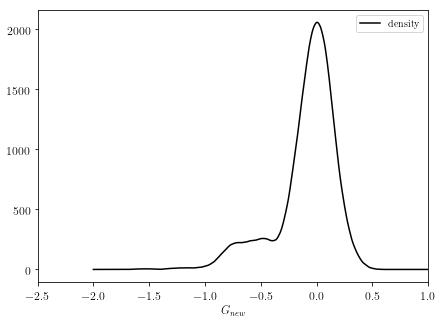

In [79]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2.5, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

## approximation with gauss function

In [80]:
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2 / c)

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-35:row_max+85, 0], profile.iloc[row_max-35:row_max+85, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0],
                                   [3000, profile.iloc[row_max, 0]+0.1, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

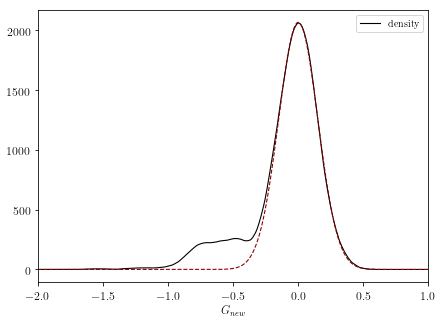

In [81]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.1, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.1, ls='--', color='darkred', label='_nolabel')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
fig.savefig(f"{CLUSTER}_profile.pdf", bbox_inches = 'tight')

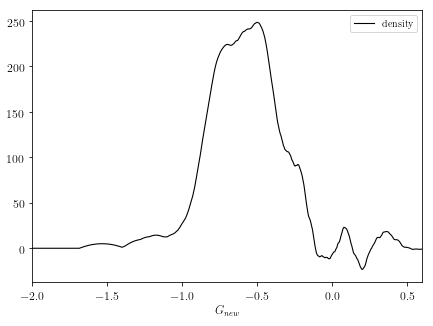

In [82]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 1.1, color = 'black')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
fig.savefig(f"{CLUSTER}_profile_binaries.pdf", bbox_inches = 'tight')

## estimation of binaries number

In [83]:
difference = profile['density'] - profile_gauss['density']
difference[difference < 0] = 0

number_of_multiples = int(integrate.trapz(difference, profile['x']))

In [84]:
# доля двойных из интегрирования профиля
number_of_multiples / len(all_stars_data)

0.1561822125813449

In [85]:
# доля двойных из "первичного отбора"
len(binaries_data) / (len(binaries_data) + len(singles_data))

0.14099783080260303

In [45]:
clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx', index_col = 0)

In [46]:
clusters_list.loc[CLUSTER, 'N_binaries'] = number_of_multiples
clusters_list.loc[CLUSTER, 'N_singles'] = clusters_list.loc[CLUSTER, 'N'] - number_of_multiples
clusters_list.loc[CLUSTER, 'fraction'] = number_of_multiples / clusters_list.loc[CLUSTER, 'N']

In [23]:
clusters_list.to_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx')